In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
import tensorflow as tf
from tensorflow import keras

2024-03-29 07:52:42.722868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:52:42.723027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:52:42.894879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#reading the data and making the date is the index
data=pd.read_csv('NFLX.csv',index_col='Date',parse_dates=True)

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [5]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2018-02-05 to 2022-02-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1009 non-null   float64
 1   High       1009 non-null   float64
 2   Low        1009 non-null   float64
 3   Close      1009 non-null   float64
 4   Adj Close  1009 non-null   float64
 5   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.2 KB


In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


- There is no NaN data
- Date handled already
- next step is ploting our Data to see what is the important feature

# Ploting Data

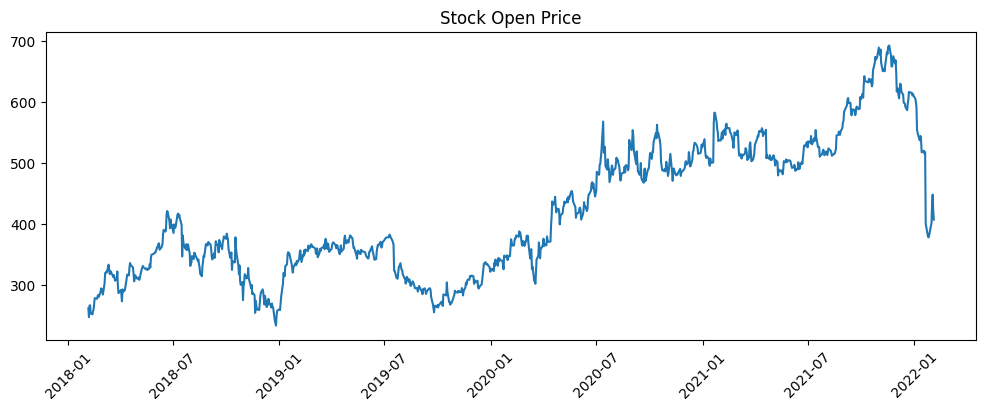

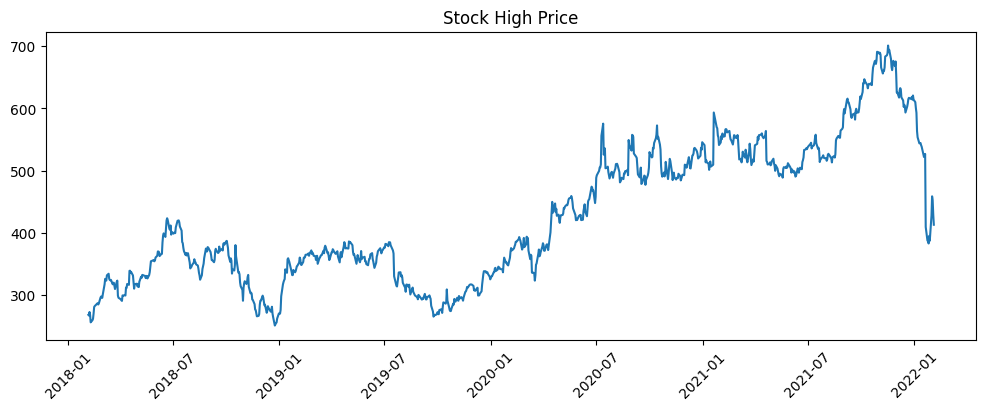

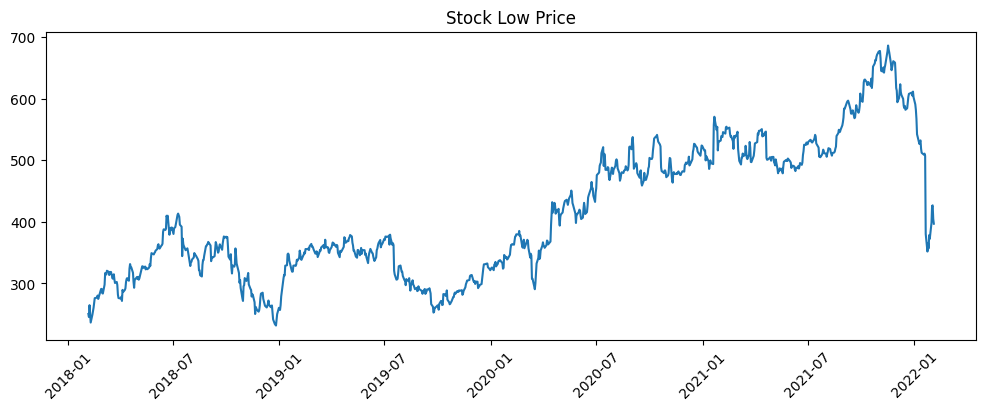

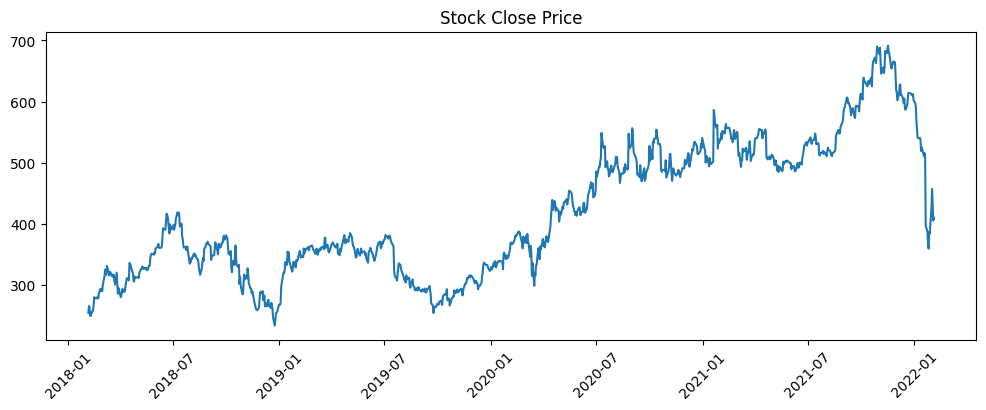

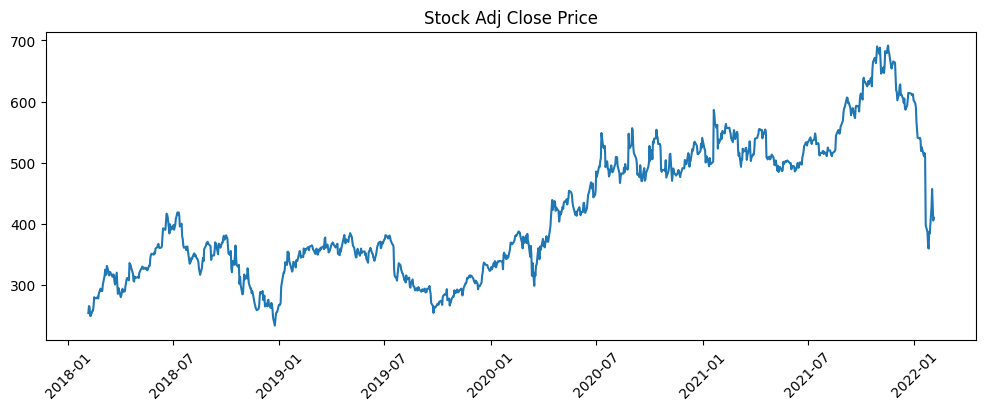

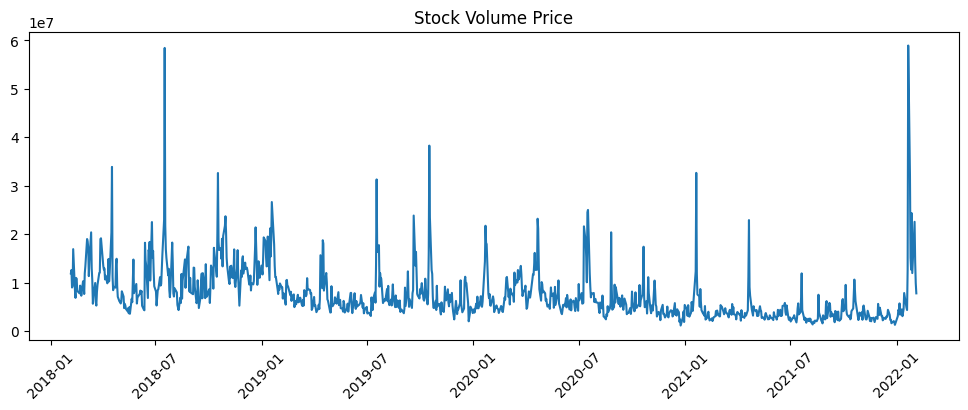

In [8]:
for columns in data.columns:
    plt.figure(figsize=(12,4))
    plt.title(f"Stock {columns} Price")
    plt.plot(data.index,data[columns])
    plt.xticks(rotation=45)

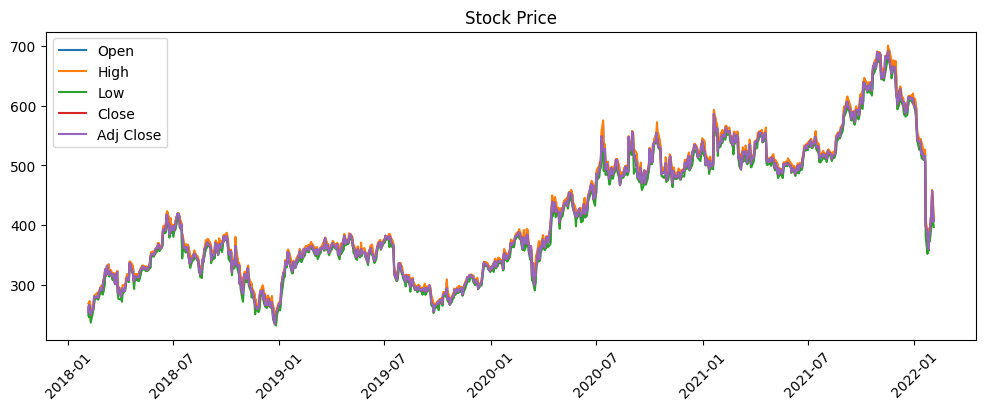

In [9]:
plt.figure(figsize=(12,4))
plt.title("Stock Price")
for columns in data.columns:
    if(columns !='Volume'):
        plt.plot(data.index,data[columns],label=columns)
plt.xticks(rotation=45)
plt.legend()

- after ploting Data we decide to take High feature to predict when the stock will be high
- next step we Data normalization

# Data Normalization

In [10]:
data=data['Close']
data.shape

(1009,)

In [11]:
data

Date
2018-02-05    254.259995
2018-02-06    265.720001
2018-02-07    264.559998
2018-02-08    250.100006
2018-02-09    249.470001
                 ...    
2022-01-31    427.140015
2022-02-01    457.130005
2022-02-02    429.480011
2022-02-03    405.600006
2022-02-04    410.170013
Name: Close, Length: 1009, dtype: float64

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))

In [13]:
# df=scaler.fit_transform(np.array(data['Close']).reshape(-1,1))
df=scaler.fit_transform(np.array(data).reshape([data.shape[0],1]))

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(df,test_size=0.2,random_state=0)

In [26]:
X_train.shape

(807, 100, 1)

In [16]:
X_test.shape

(202, 1)

# Convert array Values into a dataset values

In [17]:
def create_seq(data,time_step=60):
    X=[]
    y=[]
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        y.append(data[i+time_step])
    return X,y

In [18]:
time_step=100
X,y=create_seq(df,time_step)

In [34]:
df

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

In [19]:
len(X),len(y)

(908, 908)

## reshape input to be [samples, time-steps, features] which is required for LSTM

In [20]:
X=np.array(X)
X=X.reshape(X.shape[0],X.shape[1],1)
y=np.array(y)

In [21]:
X.shape,y.shape

((908, 100, 1), (908, 1))

## Splitting the data

In [22]:
X_train,X_test,y_train,y_test=X[:int(data.shape[0]*0.8)],X[int(data.shape[0]*0.8):],y[:int(data.shape[0]*0.8)],y[int(data.shape[0]*0.8):]

In [23]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((807, 100, 1), (101, 100, 1), (807, 1), (101, 1))

In [32]:
X_train

array([[[0.04451626],
        [0.06954849],
        [0.06701469],
        ...,
        [0.32895744],
        [0.36152555],
        [0.34186674]],

       [[0.06954849],
        [0.06701469],
        [0.03542955],
        ...,
        [0.36152555],
        [0.34186674],
        [0.35285382]],

       [[0.06701469],
        [0.03542955],
        [0.03405342],
        ...,
        [0.34186674],
        [0.35285382],
        [0.34413837]],

       ...,

       [[0.68294702],
        [0.70020314],
        [0.68956555],
        ...,
        [0.77471   ],
        [0.77903503],
        [0.81437719]],

       [[0.70020314],
        [0.68956555],
        [0.60072954],
        ...,
        [0.77903503],
        [0.81437719],
        [0.81293547]],

       [[0.68956555],
        [0.60072954],
        [0.60046743],
        ...,
        [0.81437719],
        [0.81293547],
        [0.79434695]]])

# Model

In [24]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=X_train[0].shape))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),loss="mean_squared_error",metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 128929 (503.63 KB)
Trainable params: 128929 (503.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Model

In [28]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
26/26 [==============================] - 8s 163ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593
Epoch 2/10
26/26 [==============================] - 4s 161ms/step - loss: 0.0033 - root_mean_squared_error: 0.0572
Epoch 3/10
26/26 [==============================] - 4s 158ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538
Epoch 4/10
26/26 [==============================] - 4s 171ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536
Epoch 5/10
26/26 [==============================] - 4s 158ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508
Epoch 6/10
26/26 [==============================] - 4s 158ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494
Epoch 7/10
26/26 [==============================] - 4s 158ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507
Epoch 8/10
26/26 [==============================] - 4s 159ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468
Epoch 9/10
26/26 [==============================] - 4s 162ms/step - loss: 0.0021

## Test the Model

In [29]:
trainPred=model.predict(X_train)
testPred=model.predict(X_test)
trainPred=scaler.inverse_transform(trainPred)
testPred=scaler.inverse_transform(testPred)

4/4 [==============================] - 0s 56ms/step


## Model performance

In [ ]:
model.evaluate(X_test,y_test)

## Ploting Performance

In [ ]:
look_back=time_step
# shift train predictions for plotting (time step)

trainPredPlot=np.empty_like(scaler.inverse_transform(df))
trainPredPlot[:]=np.nan
trainPredPlot[look_back:len(trainPred)+look_back]=trainPred

#shift test predictions for plotting(time_step)
testPredPlot=np.empty_like(scaler.inverse_transform(df))
testPredPlot[:]=np.nan
testPredPlot[len(trainPred)+look_back:len(trainPred)+look_back+len(testPred)]=testPred


In [ ]:
plt.plot(scaler.inverse_transform(df),label="Actual close price")
plt.plot(trainPredPlot,label="Training prediction close price")
plt.plot(testPredPlot,label="Predicted close price")
plt.legend()
plt.show()

# Next 30 days prediction

In [ ]:
predection_data=np.array(data[-time_step:])
predection_data=predection_data.reshape([predection_data.shape[0],1])

In [ ]:
def predication(data,days=30):
    data=scaler.transform(data)
    pred=[]
    for i in range(1,days+1):
        nxt_day=model.predict([data],verbose=0)
        pred.append(scaler.inverse_transform(nxt_day)[0])
        data[:-1]=data[1:]
        data[-1]=nxt_day[0]
    return np.array(pred).squeeze()

In [ ]:
days=30
res=predication(predection_data,days)

In [ ]:
trainPredPlot=np.zeros(shape=[len(predection_data)+1+days])
trainPredPlot[:]=np.nan
trainPredPlot[len(predection_data)]=res[-1]
trainPredPlot[len(predection_data)+1:]=res
df_=predection_data
plt.plot(df_,label="Actual close price")
plt.plot(trainPredPlot,label="Predicted close price")
plt.legend()
plt.show()